# Algoritmo RLS: ejemplo básico

Ignacio Díaz Blanco, 2019. Universidad de Oviedo

## Descripción
Este notebook muestra un ejemplo básico de aplicación de RLS, con datos simulados, donde se hace un seguimiento "tracking" del comportamiento dinámico de un sistema a partir de sus entradas $u(k)$ y salidas $y(k)$



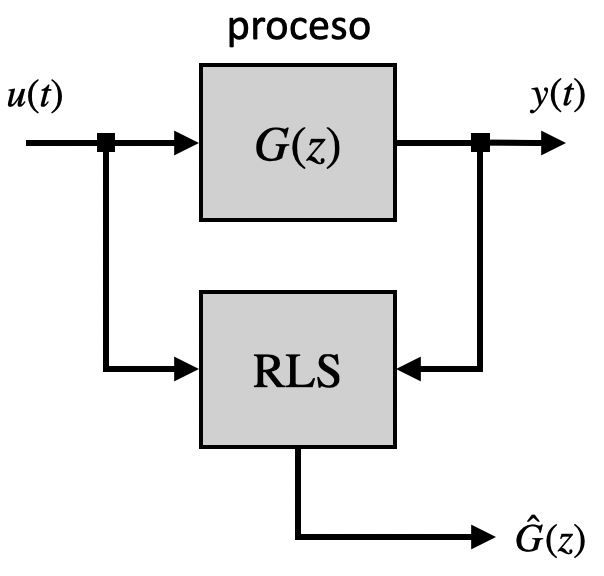

In [1]:
from IPython.display import Image, display

display(Image(filename="figura_RLS.png", width=600))

In [2]:
from pylab import *
from scipy.signal import lfilter
from IPython.core.display import HTML


Para hacer las pruebas, definimos dos sistemas con las siguientes funciones de transferencia

$$
G_1(z) = \frac{1+z^{-1}}{1 -z^{-1} + 0.9 z^{-2}} \qquad G_2(z) = \frac{1+0.5z^{-1}}{1 -z^{-1} + 0.5 z^{-2}}
$$

... y a continuación los aplicamos consecutivamente, conmutando de uno al otro a la mitad: 1000 muestras con el primero y las siguientes 1000 muestras con el segundo

Esto simula una situación en la que un proceso industrial modifica su comportamiento dinámico. La identifiación de sistemas, evaluada de forma recursiva, nos permite hacer un "tracking" de su función de trasnferencia, revelando
cambios en su comportamiento dinámico.

In [3]:
# filtramos con una función de transferencia (num1,den1)
u1 = randn(1000)
num1 = [1, 1]
den1 = [1, -1, 0.9]
(y1,zf) = lfilter(num1,den1,u1,zi=zeros(2))

In [4]:
# a partir de una muestra dada, filtramos con función de transferencia (num2,den2)
num2 = [1,.5]
den2 = [1,-1,0.5]
u2   = randn(1000)
(y2,zf) = lfilter(num2,den2,u2,zi=zf)

# nótese que hemos concatenado ambas simulaciones 
# considerando los estados finales (zf) del filtro tras la primera simulación, 
# tomándolos como iniciales (zi) en la segunda simulación

In [5]:
# concatenamos ambas simulaciones
u = hstack((u1,u2))
y = hstack((y1,y2))

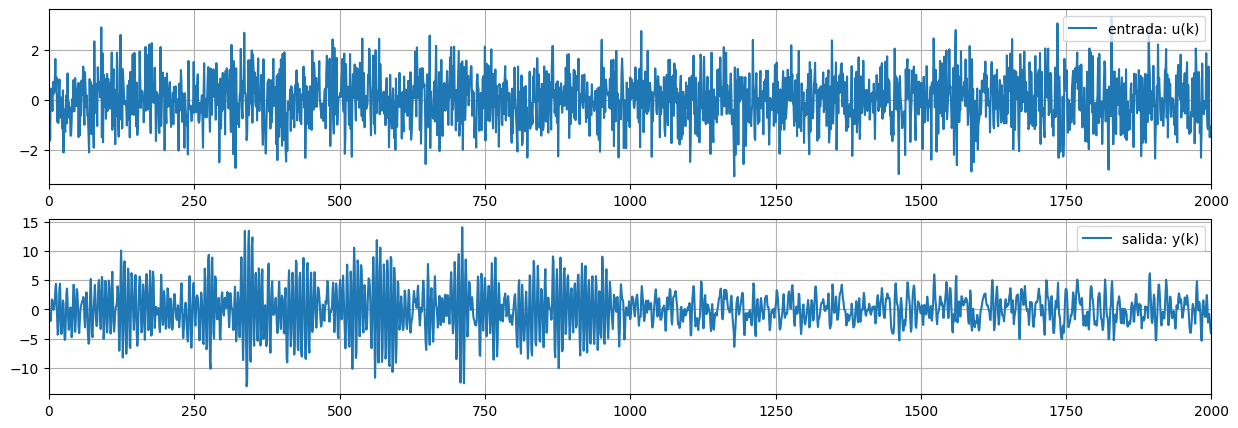

In [6]:
# mostramos los resultados de las simulaciones

figure(figsize=(15,5))

subplot(2,1,1)
plot(u)
legend(['entrada: u(k)'])
grid(True)
axis(xmin=0,xmax=2000)

subplot(2,1,2)
plot(y);
legend(['salida: y(k)'])
grid(True)
axis(xmin=0,xmax=2000);


## Algoritmo RLS

In [7]:
# órdenes de numerador, denominador y matrices
nu = 1
ny = 2
n  = nu+ny+1

# tamaño inicial de la incertidumbre P (grande)
alpha = 1e5

# factor de olvido
lmb = 0.95

# inicialización de matrices varias
I  = eye(n)
P  = alpha*I
th = zeros(n)[:,None]

# algoritmo RLS
th_ = []
for k in range(3,u.shape[0]):
    # actualizamos el vector de datos phi, con los retardos de u e y
    idxu = arange(0,nu+1)
    idxy = arange(1,ny+1)
    phi = hstack((u[k-idxu],y[k-idxy]))[:,None]
    
    # ecuaciones de RLS
    L = (P@phi)*inv((phi.T@P@phi) + lmb)
    e = y[k] - phi.T@th
    th = th + L@e
    P = (1/lmb)*(I - L@phi.T)@P
    
    # guardamos un histórico de th para representarlo después
    th_.append(th.ravel())

th_ = array(th_)

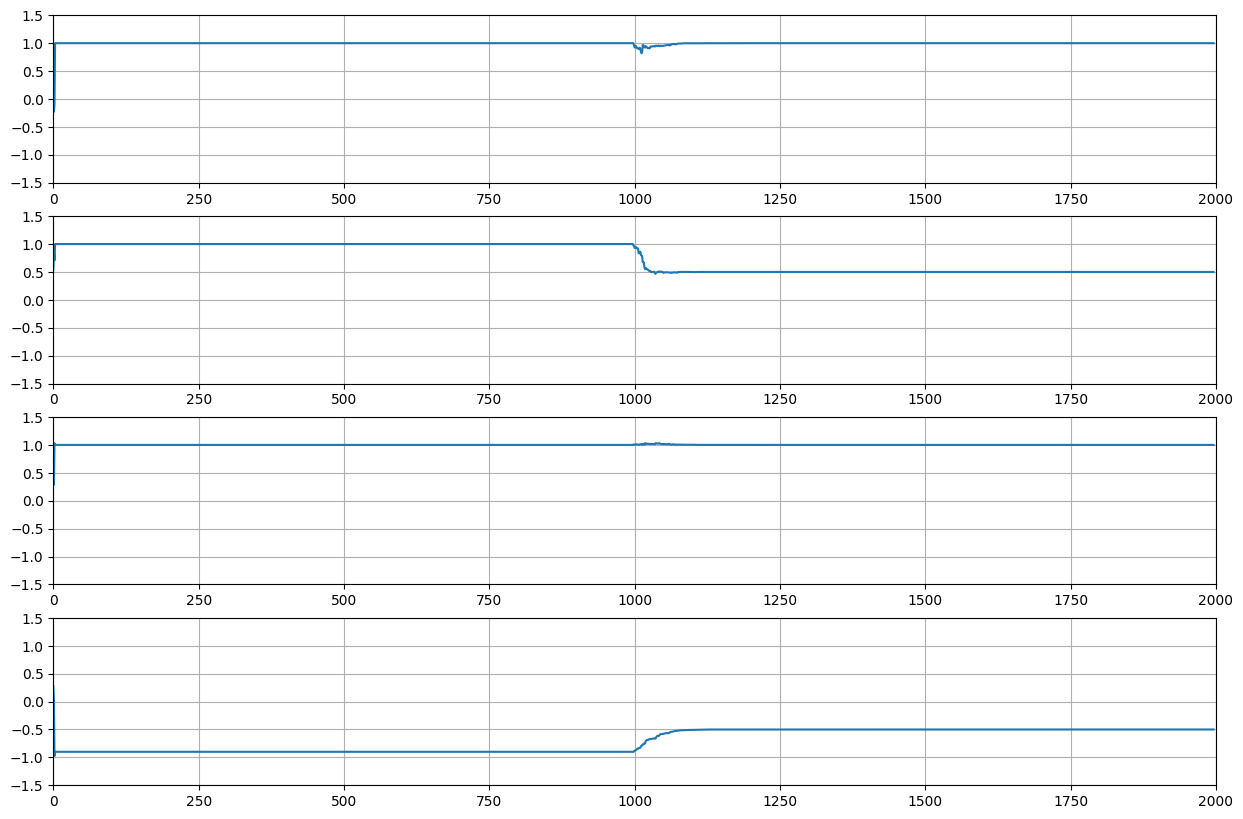

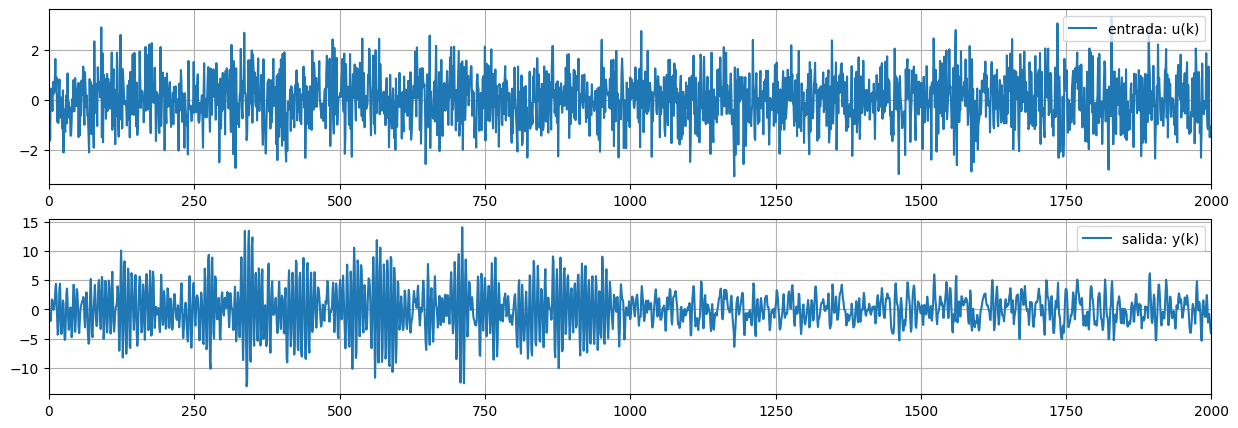

In [8]:
# VISUALIZACIÓN DE LA ESTIMACIÓN RLS DE LOS COEFICIENTES

figure(figsize=(15,10))
for i in range(n):
    subplot(n,1,i+1)
    plot(th_[:,i])
    axis(ymin=-1.5,ymax=1.5)
    grid(True)
    axis(xmin=0,xmax=2000)


figure(figsize=(15,5))

subplot(2,1,1)
plot(u)
legend(['entrada: u(k)'])
grid(True)
axis(xmin=0,xmax=2000)

subplot(2,1,2)
plot(y);
legend(['salida: y(k)'])
grid(True)
axis(xmin=0,xmax=2000);